**In this notebook we are going to predict number of points, based on input features. As well as analyzing the most frequent terms in wine industry.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('winemag-data_first150k.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df.describe()

,points,price
count,150930.000000,137235.000000
mean,87.888418,33.131482
std,3.222392,36.322536
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 10 columns):
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 11.5+ MB


In [6]:
df.shape

(150930, 10)

In [7]:
df.isnull().sum()

country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64

In [8]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
region_2,89977,59.615053
designation,45735,30.302127
region_1,25060,16.603724
price,13695,9.073743
province,5,0.003313
country,5,0.003313
winery,0,0.000000
variety,0,0.000000
points,0,0.000000
description,0,0.000000


**Let's check the price distribution**

In [9]:
df=df.dropna(subset=['price'])

Text(0.5,0,'Wine Price')

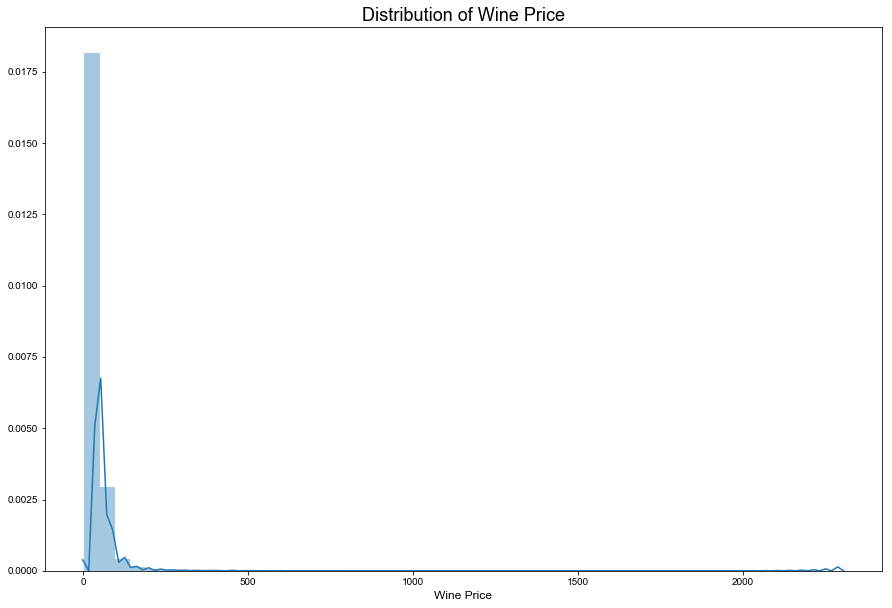

In [10]:
plt.figure(figsize=(15,10))
sns.distplot(df['price'], bins=50)
sns.set_style('whitegrid')
plt.title('Distribution of Wine Price', fontsize=18)
plt.xlabel('Wine Price', fontsize=12)

** In order to see better price distribution we have to scale our price**

Text(0.5,0,'Wine Price')

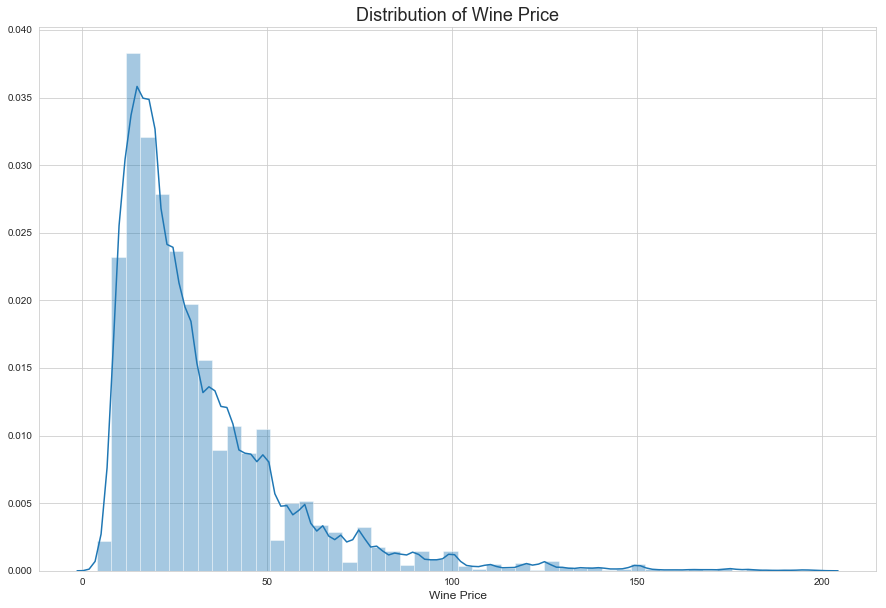

In [11]:
plt.figure(figsize=(15,10))
sns.distplot(df[df['price']<200]['price'], bins=50)
sns.set_style('whitegrid')
plt.title('Distribution of Wine Price', fontsize=18)
plt.xlabel('Wine Price', fontsize=12)

In [12]:
s = df.groupby('country')['points', 'price'].mean().reset_index().sort_values('price',ascending=False)
s.head(10)

,country,points,price
43,US-France,88.000000,50.000000
13,England,92.750000,47.500000
14,France,88.603314,45.619885
18,Hungary,87.304348,44.204348
25,Luxembourg,87.000000,40.666667
16,Germany,88.610567,39.011078
21,Italy,88.445006,37.547913
7,Canada,88.221649,34.628866
42,US,87.817200,33.653808
20,Israel,87.155738,31.304918


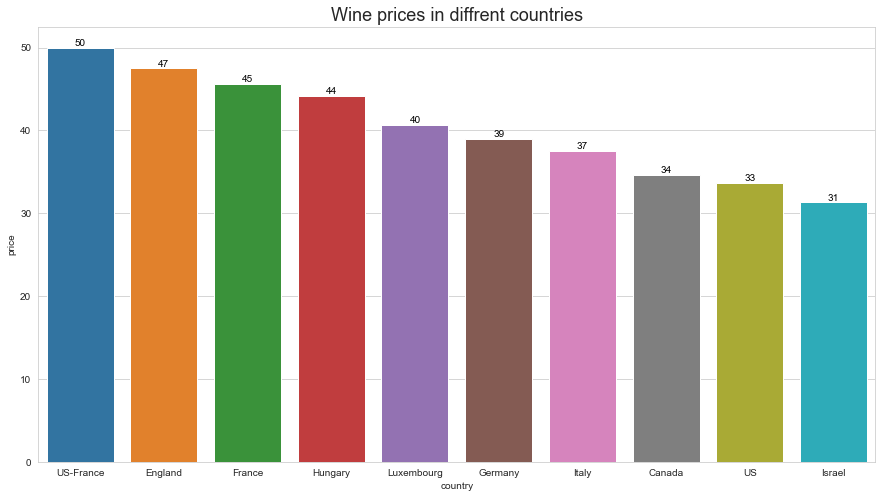

In [13]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='country', y='price', data=s.head(10))
plt.title('Wine prices in diffrent countries', fontsize=18)
for p in ax.patches:
     ax.text(p.get_x() + p.get_width()/2., p.get_height(),  '%d' % int(p.get_height()),
            fontsize=10, color='black', ha='center', va='bottom')

**Feature selection**

In [14]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, cv

X=df.drop(['points','description'], axis=1)
X=X.fillna(-1)
y = df['points']

print(X.columns)

categorical_features_indices =[0,1,3,4,5,6,7]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, 
                                                    random_state=2)

Index(['country', 'designation', 'price', 'province', 'region_1', 'region_2',
       'variety', 'winery'],
      dtype='object')


In [15]:
def perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test):
    model = CatBoostRegressor(
        random_seed = 400,
        loss_function = 'RMSE',
        iterations=400,
    )
    
    model.fit(
        X_train, y_train,
        cat_features = categorical_features_indices,
        eval_set=(X_valid, y_valid),
        verbose=False
    )
    
    print("RMSE on training data: "+ model.score(X_train, y_train).astype(str))
    print("RMSE on test data: "+ model.score(X_test, y_test).astype(str))
    
    return model

In [16]:
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)

RMSE on training data: 1.9498444727176787
RMSE on test data: 2.1775003247199587


**Plot feature importance**

In [17]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

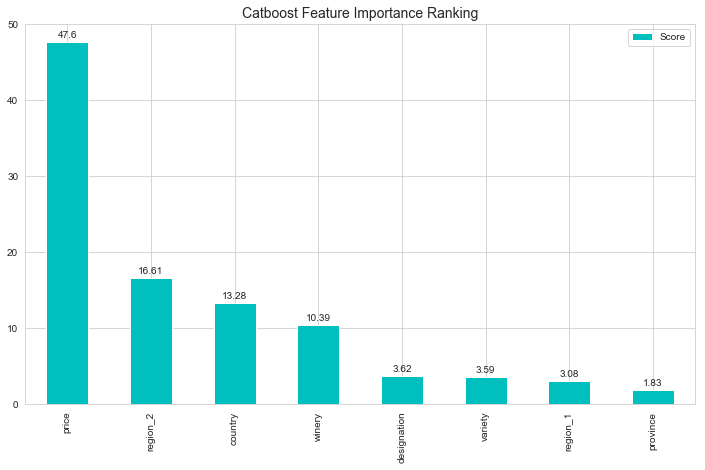

In [18]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()


# NLP section

In [19]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [20]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [21]:
words = df['description'].str.split(expand=True).unstack().value_counts()
words.head()

and     374829
the     186634
a       169783
of      168535
with    135402
dtype: int64

**Cleaning words (Remove Punctuation and Stopwords and Stemming)**



In [22]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamiezeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [24]:
df['description'] = df['description'].apply(remove_punctuation)

In [25]:
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

In [26]:
df['description'] = df['description'].apply(remove_stopwords)

In [27]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def stemming(text):    
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [28]:
df['description'] = df['description'].apply(stemming)

In [29]:
word = df['description'].str.split(expand=True).unstack().value_counts()
word.head()

wine      82705
flavor    81972
fruit     60581
finish    43494
cherri    36309
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

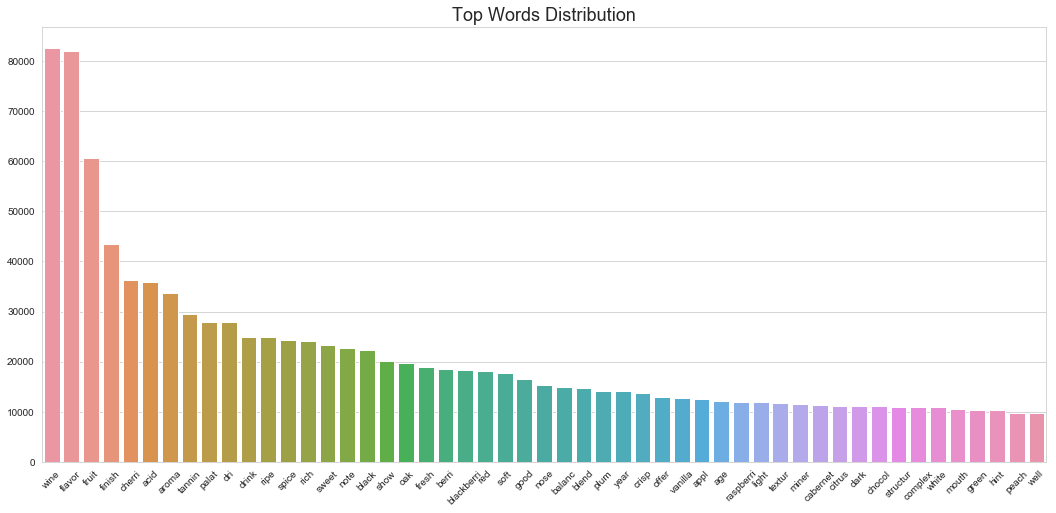

In [36]:
plt.figure(figsize=(18,8))
sns.barplot(x=word.index[:51], y=word.values[:51])
plt.title('Top Words Distribution', fontsize=18)
plt.xticks(rotation= 45)

In [30]:
trace=[go.Bar(
        x=word.index[:51],
        y=word.values[:51], 
        marker= dict(colorscale='Viridis', color = word.values[:51]),
        text='Word counts', 
        )]

layout = go.Layout(title='Top Words Distribution', xaxis=dict(tickangle=-45))
fig = go.Figure(data=trace, layout=layout)
py.iplot(fig)

**As we can see, the top terms in wine industry include fruit, acid, aroma, spice ect.  Flavor varies from cherri, sweet, berri, blackberri, plum.**